# Регрессионный анализ качества красного вина

Дано: данные о химическом составе вина и оценка, данная экспертом
Требуется: провести регрессионный анализ

## Импортируем модули и данные

In [1010]:
# Для работы с данными
import pandas as pd
import numpy as np
# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# scipy
from scipy.stats import t
# statmodels
from statsmodels.stats.outliers_influence import  variance_inflation_factor as vif
import statsmodels.api as sm

np.random.seed(100)

In [973]:
df_main = pd.read_csv('data/winequality-red.csv')
df_main.columns = list(map(lambda x: x.replace(' ', '_'), df_main.columns))
df_main

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [974]:
def get_X_y(df):
    X = df.drop('quality', axis=1)
    y = df['quality']
    return X, y

def compute_r_squared(df_train, df_test):
    model = LinearRegression()
    X_train, y_train = get_X_y(df_train)
    X_test, y_test = get_X_y(df_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    print('test data R squared:', r_squared)

## Train test split

In [975]:
df_train,df_test =train_test_split(df_main)

In [976]:
compute_r_squared(df_train, df_test)

test data R squared: 0.3292951166074203


## Матрица корреляции

In [977]:
def plot_correlation_heatmap(df, figsize=(6, 6), abs_flag=True, ax=None):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()


    corr_matr = df.corr()
    if abs_flag:
        corr_matr = corr_matr.abs()
    corr_matr.sort_values('quality', inplace=True)
    corr_matr[corr_matr == 1] = 0
    sns.heatmap(corr_matr, square=True, annot=True, cmap='YlGnBu', ax=ax)

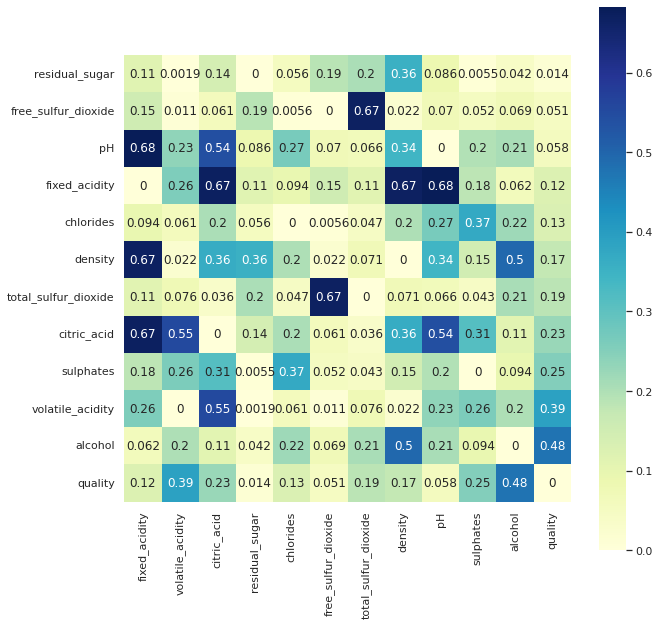

In [978]:
plot_correlation_heatmap(df_main, abs_flag=True, figsize=(10, 10))

## Отбираем переменные при помощи VIF

In [979]:


def get_vifs(df, drop_columns=[]):
    df = df.copy()
    df['intercept'] = 1
    if drop_columns:
        df.drop(drop_columns, axis=1, inplace=True)
    vif_df = pd.Series({df.columns[i]: vif(df, i) for i in range(df.shape[1])})
    return vif_df.drop('intercept').sort_values(ascending=False)

In [980]:
get_vifs(df_main, 'quality')

fixed_acidity           7.767512
density                 6.343760
pH                      3.329732
citric_acid             3.128022
alcohol                 3.031160
total_sulfur_dioxide    2.186813
free_sulfur_dioxide     1.963019
volatile_acidity        1.789390
residual_sugar          1.702588
chlorides               1.481932
sulphates               1.429434
dtype: float64

In [981]:
get_vifs(df_main, 'fixed_acidity')

citric_acid             2.782222
density                 2.430116
alcohol                 2.365045
total_sulfur_dioxide    2.099856
free_sulfur_dioxide     1.944737
volatile_acidity        1.874221
pH                      1.627819
quality                 1.562935
sulphates               1.452106
chlorides               1.421802
residual_sugar          1.386862
dtype: float64

In [982]:
get_vifs(df_main, 'density')

citric_acid             3.130857
fixed_acidity           2.975973
pH                      2.253940
total_sulfur_dioxide    2.201691
free_sulfur_dioxide     1.954036
volatile_acidity        1.852268
quality                 1.563175
alcohol                 1.532875
chlorides               1.488196
sulphates               1.396431
residual_sugar          1.099815
dtype: float64

Вывод: можно откинуть любую из переменных, но т.к. density имеет более большую корреляцию и у нее лучше VIF, то мы откинем ее

In [983]:
df_train.drop('fixed_acidity', axis=1, inplace=True)
df_test.drop('fixed_acidity', axis=1, inplace=True)
compute_r_squared(df_train, df_test)

test data R squared: 0.3284229246574031


/tmp/ipykernel_393463/3163163501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('fixed_acidity', axis=1, inplace=True)
/tmp/ipykernel_393463/3163163501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop('fixed_acidity', axis=1, inplace=True)


## Forward feature selection with bic

### Эксперинменты

In [984]:
def get_aic_from_data(X, y):
    model = sm.OLS(y, X).fit()
    return model.aic

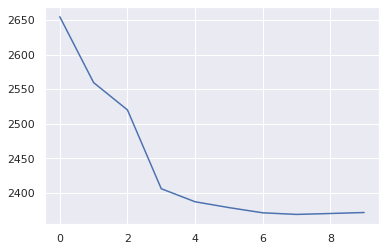

In [985]:
unselected_features = df_train.columns.to_list()
unselected_features.remove('quality')
unselected_features = set(unselected_features)

selected_features = []
y = df_train['quality']
aic_list = []
for n_features in range(1, len(unselected_features)+1):
    lowest_aic = float('inf')
    best_feature = None
    for feature in unselected_features:
        X = df_train[selected_features + [feature]]
        aic = get_aic_from_data(X, y)
        if aic < lowest_aic:
            lowest_aic = aic
            best_feature = feature
    aic_list.append(lowest_aic)
    unselected_features.remove(best_feature)
    selected_features.append(best_feature)
plt.plot(aic_list)

Вывод: лучше всего сохранить все фичи

In [986]:
# top_features = selected_features[:6]
# top_features

In [987]:
# df_train = df_train[top_features + ['quality']]
# df_test = df_test[top_features + ['quality']]

In [988]:
compute_r_squared(df_train, df_test)

test data R squared: 0.3284229246574031


## Outlier detection

### Studenized residuals

In [989]:
model1 = sm.OLS(df_train['quality'], sm.add_constant(get_X_y(df_train)[0])).fit()
print_model1 = model1.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     69.21
Date:                Mon, 25 Apr 2022   Prob (F-statistic):          3.67e-111
Time:                        13:23:44   Log-Likelihood:                -1175.6
No. Observations:                1199   AIC:                             2373.
Df Residuals:                    1188   BIC:                             2429.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.4607 

In [990]:

influence = model1.get_influence()
influence_frame = influence.summary_frame()
student_resid = influence.resid_studentized_external
cooks = influence.cooks_distance
dffits = influence.dffits
leverage = influence.hat_matrix_diag
influence_frame.columns

Index(['dfb_const', 'dfb_volatile_acidity', 'dfb_citric_acid',
       'dfb_residual_sugar', 'dfb_chlorides', 'dfb_free_sulfur_dioxide',
       'dfb_total_sulfur_dioxide', 'dfb_density', 'dfb_pH', 'dfb_sulphates',
       'dfb_alcohol', 'cooks_d', 'standard_resid', 'hat_diag',
       'dffits_internal', 'student_resid', 'dffits'],
      dtype='object')

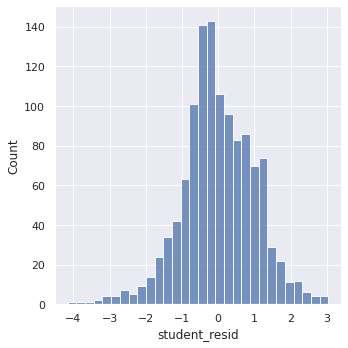

In [991]:
sns.displot(x=influence_frame['student_resid'])

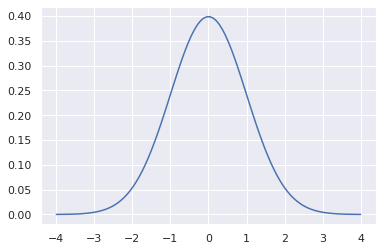

In [993]:
x = np.linspace(-4, 4, 100)
n = len(df_train)
t_dist = t(n-3)
y = t_dist.pdf(x)
plt.plot(x, y)

In [994]:
p_value = t_dist.cdf(-3) * 2
print('Вероятность того, что значени с отклонение на 3 большее по модулю не выброс', p_value)

Вероятность того, что значени с отклонение на 3 большее по модулю не выброс 0.002755683752087083


In [995]:
student_resid_threshhold = 3

Вывод удалим все, у кого studenized residuals больше 3-х

###  DFITS

In [996]:
influence_frame['dffits']

896     0.041687
1140    0.071760
48     -0.056644
1532    0.030918
1223   -0.047652
          ...   
53     -0.034856
350     0.058065
79     -0.279433
792     0.117095
1544    0.068235
Name: dffits, Length: 1199, dtype: float64

detected as outliers 0.05754795663052544


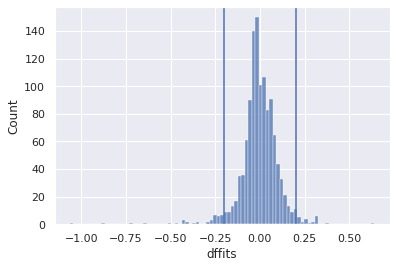

In [997]:
n = len(df_train)
k = df_train.shape[1] + 1
dfits_threshhold = 2 * np.sqrt(k / n)

ax = plt.subplots(1, 1)[1]
sns.histplot(data=influence_frame, x='dffits', ax=ax)
ax.axvline(-dfits_threshhold)
ax.axvline(dfits_threshhold)

vals_less = 0
vals_less += np.mean(influence_frame['dffits'] < -dfits_threshhold)
vals_less += np.mean(influence_frame['dffits'] > dfits_threshhold)
print('detected as outliers', vals_less)

### Cook's distance

In [998]:
influence_frame['cooks_d']

896     0.000158
1140    0.000468
48      0.000292
1532    0.000087
1223    0.000207
          ...   
53      0.000111
350     0.000307
79      0.007077
792     0.001245
1544    0.000423
Name: cooks_d, Length: 1199, dtype: float64

<AxesSubplot:xlabel='cooks_d', ylabel='Count'>

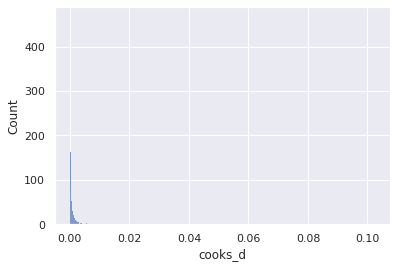

In [999]:
sns.histplot(data=influence_frame, x='cooks_d')

In [1000]:
cooks_d = influence_frame['cooks_d']
cooks_d.sort_values(ascending=False)

151     1.022980e-01
1235    7.063388e-02
652     4.627120e-02
92      3.784381e-02
1081    3.720950e-02
            ...     
629     1.011729e-08
1407    9.387564e-09
163     8.193371e-09
918     7.732098e-09
921     7.732098e-09
Name: cooks_d, Length: 1199, dtype: float64

<AxesSubplot:xlabel='cooks_d', ylabel='Count'>

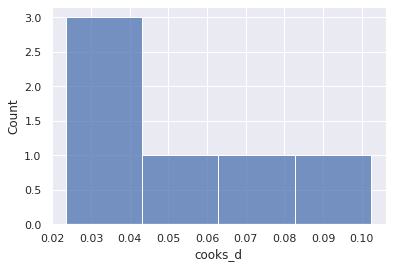

In [1001]:
mask = influence_frame['cooks_d'] > 0.02
sns.histplot(data=influence_frame[mask], x='cooks_d')

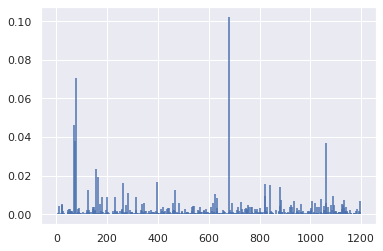

In [1002]:
cooks_d = influence_frame['cooks_d']
n = len(cooks_d)

plt.vlines(np.arange(n), np.zeros((n)), cooks_d)

In [1003]:
threshhold = 0.02
np.mean(influence_frame['cooks_d'] > threshhold)

0.0050041701417848205

In [1004]:
cooks_threshhold = threshhold

### Сколько раз совпали метрики

In [1005]:
cook_outliers = influence_frame['cooks_d'] > cooks_threshhold
dfits_outliers = influence_frame['dffits'] > dfits_threshhold
student_resid_outliers = influence_frame['student_resid'] > student_resid_threshhold
outliers_df = pd.concat([cook_outliers, dfits_outliers, student_resid_outliers], axis=1)

In [1006]:
alarms = outliers_df.sum(axis=1).sort_values(ascending=False)
alarms

440     2
1081    2
828     1
364     1
566     1
       ..
413     0
391     0
1523    0
265     0
1544    0
Length: 1199, dtype: int64

In [1007]:

for metrics_threshhold in range(1, 4):
    outliers = np.sum(alarms >= metrics_threshhold)
    print(f'#метрик сработало: {metrics_threshhold},  #выбросы: {outliers}')

#метрик сработало: 1,  #выбросы: 35
#метрик сработало: 2,  #выбросы: 2
#метрик сработало: 3,  #выбросы: 0


Вывод: срабатывания одной метрики достаточно, чтобы отбросить сэмпл

### Удаляем

In [1008]:
df_train = df_train.loc[(alarms[alarms<1]).index]

## Пересчитываем модель

In [1009]:
model = LinearRegression()
X_train = df_train.drop('quality', axis=1)
y_train = df_train['quality']
X_test = df_test.drop('quality', axis=1)
y_test = df_test['quality']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r_squared = r2_score(y_test, y_pred)
print('test data R squared:', r_squared)

test data R squared: 0.3404765697832609


Результаты работы:
* Удалось разобраться с multicollinearity при помощи VIF
* Удалось реализовать отбор параметров при помощи  AIC
* Удалось разобраться с модулем statmodels
* Удалось убрать выбросы, что привело к улучшению R-squared

Что делать дальше:
* Понять чем плоха multicollinearity
* Использовать биномальную регрессию
* Сравнить резудьтаты работы с результатами на сайте института